# MVP Engenharia de Dados - Databricks

##     Visão geral do projeto:

Este projeto demonstra um pipeline de dados completo usando o Databricks Community Edition, desde a extração de dados públicos até a criação de dashboards. Vamos utilizar como alicerce os dados de COVID-19 do site "Our World in Data", os quais são atualizados diariamente e também disponíveis publicamente. Para efeito de corte, os dados estão atualizados até o mês de agosto de 2024.

##    Estrutura do projeto
 
 O projeto utilizará a chamada arquitetura de camadas, estrutura clássica na área de Engenharia de Dados. As camadas estão divididas em:
- Camada Bronze: Onde se localizam os dados brutos
- Camada Silver: Dados limpos e transformados
- Camada Gold: Dados agregados para análises ou estudos futuros


##  Implementação:

**A ) Configurações iniciais:**

In [0]:
# Verificar se estamos no Databricks
dbutils.fs.ls("/")

# Criar diretórios (usando dbfs:/ em vez de /dbfs)
dbutils.fs.mkdirs("dbfs:/mnt/covid_data/bronze")
dbutils.fs.mkdirs("dbfs:/mnt/covid_data/silver")
dbutils.fs.mkdirs("dbfs:/mnt/covid_data/gold")

Out[1]: True

**B ) Camada Bronze - Extração e ingestão de dados**

In [0]:
# Método alternativo que funciona na Community Edition, em virtude de limitações na plataforma gratuita
import pandas as pd
from io import StringIO
import requests

# URL dos dados (fonte original)
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

# Baixar os dados diretamente para um DataFrame pandas
response = requests.get(url)
csv_data = StringIO(response.text)
pdf = pd.read_csv(csv_data)

# Converter para Spark DataFrame e salvar como formato Delta
bronze_path = "dbfs:/mnt/covid_data/bronze/owid-covid-data.delta"
spark_df = spark.createDataFrame(pdf)
spark_df.write.format("delta").mode("overwrite").save(bronze_path)

# Registrar tabela
spark.sql("""
CREATE TABLE IF NOT EXISTS bronze_covid_data
USING DELTA
LOCATION 'dbfs:/mnt/covid_data/bronze/owid-covid-data.delta'
""")

Out[2]: DataFrame[]

**C ) Verificação da Camada Bronze**

In [0]:
# Verificar se os dados foram carregados corretamente ("Check")
display(spark.sql("SELECT COUNT(*) FROM bronze_covid_data"))
display(spark.sql("SELECT * FROM bronze_covid_data LIMIT 5"))

count(1)
429435


iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,54.422,18.6,2.581,1.337,1803.987,null,597.029,9.59,null,null,37.746,0.5,64.83,0.511,41128772,null,null,null,null
AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,54.422,18.6,2.581,1.337,1803.987,null,597.029,9.59,null,null,37.746,0.5,64.83,0.511,41128772,null,null,null,null
AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,54.422,18.6,2.581,1.337,1803.987,null,597.029,9.59,null,null,37.746,0.5,64.83,0.511,41128772,null,null,null,null
AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,54.422,18.6,2.581,1.337,1803.987,null,597.029,9.59,null,null,37.746,0.5,64.83,0.511,41128772,null,null,null,null
AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,54.422,18.6,2.581,1.337,1803.987,null,597.029,9.59,null,null,37.746,0.5,64.83,0.511,41128772,null,null,null,null


**D ) Camada Silver - Limpeza e transformação dos dados**

In [0]:
from pyspark.sql.functions import col, to_date

# Ler da tabela bronze
silver_df = spark.sql("""
SELECT
    iso_code AS country_code,
    location AS country_name,
    continent,
    to_date(date) AS date,
    total_cases,
    new_cases,
    total_deaths,
    new_deaths,
    population,
    gdp_per_capita,
    human_development_index
FROM bronze_covid_data
WHERE continent IS NOT NULL
""")

# Escrever na camada silver
silver_path = "dbfs:/mnt/covid_data/silver/covid_data.delta"
silver_df.write.format("delta").mode("overwrite").save(silver_path)

# Registrar tabela
spark.sql("""
CREATE TABLE IF NOT EXISTS silver_covid_data
USING DELTA
LOCATION 'dbfs:/mnt/covid_data/silver/covid_data.delta'
""")

Out[4]: DataFrame[]

In [0]:
# Consulta à tabela criada na camada Silver para saber se foi criada corretamente:
display(spark.sql("SELECT * FROM silver_covid_data ORDER BY population DESC LIMIT 5 "))
# Obs: Ordenação em ordem decrescente

country_code,country_name,continent,date,total_cases,new_cases,total_deaths,new_deaths,population,gdp_per_capita,human_development_index
CHN,China,Asia,2020-01-05,1.0,1.0,0.0,0.0,1425887360,15308.712,0.761
CHN,China,Asia,2020-01-09,1.0,0.0,0.0,0.0,1425887360,15308.712,0.761
CHN,China,Asia,2020-01-06,1.0,0.0,0.0,0.0,1425887360,15308.712,0.761
CHN,China,Asia,2020-01-07,1.0,0.0,0.0,0.0,1425887360,15308.712,0.761
CHN,China,Asia,2020-01-08,1.0,0.0,0.0,0.0,1425887360,15308.712,0.761


In [0]:
# Verificação de Qualidade bem completa da camada Silver (para conferir se o processo de limpeza e transformação foi executado com sucesso)
from pyspark.sql.functions import col, count, when, isnull, sum as _sum
from pyspark.sql.functions import countDistinct

def run_data_quality_checks(df, table_name):
    print(f"\n=== Verificação de Qualidade para {table_name} ===")
    
    # Verificação básica
    total_rows = df.count()
    print(f"Total de registros: {total_rows}")
    
    if total_rows == 0:
        raise ValueError("Tabela vazia - nenhum registro encontrado")
    
    # Verificar valores nulos em colunas críticas
    critical_columns = ['country_code', 'country_name', 'date', 'new_cases']
    for column in critical_columns:
        null_count = df.where(col(column).isNull()).count()
        null_percentage = (null_count / total_rows) * 100
        print(f"Valores nulos em {column}: {null_count} ({null_percentage:.2f}%)")
        
        if null_percentage > 5:  # Limite de 5% de valores nulos
            print(f"ALERTA: Alta porcentagem de nulos em {column}")
    
    # Verificar valores negativos onde não deveriam existir
    numeric_columns = ['new_cases', 'new_deaths', 'total_cases', 'total_deaths']
    for column in numeric_columns:
        negative_count = df.where(col(column) < 0).count()
        if negative_count > 0:
            print(f"ALERTA: {negative_count} valores negativos encontrados em {column}")
    
    # Verificar datas fora do range esperado
    date_stats = df.select(
        _sum(when(col('date') < '2019-12-01', 1).otherwise(0)).alias('before_2019'),
        _sum(when(col('date') > '2023-12-31', 1).otherwise(0)).alias('after_2023')
    ).collect()[0]
    
    print(f"Registros antes de 2019-12-01: {date_stats['before_2019']}")
    print(f"Registros após 2023-12-31: {date_stats['after_2023']}")
    
    # Verificar países sem continente (deveriam ter sido filtrados)
    no_continent = df.where(col('continent').isNull()).count()
    print(f"Registros sem continente: {no_continent} (deveria ser 0)")
    
    # Verificar duplicidades na chave natural
    duplicate_df = df.groupBy('country_code', 'date').count().where('count > 1')
    duplicate_count = duplicate_df.count()
    print(f"Possíveis duplicatas (mesmo país+data): {duplicate_count}")
    if duplicate_count > 0:
        print("Exemplo de duplicatas:")
        display(duplicate_df.limit(5))

# Carregar dados da camada Silver
silver_df = spark.table("silver_covid_data")

# Executar verificações
run_data_quality_checks(silver_df, "silver_covid_data")


=== Verificação de Qualidade para silver_covid_data ===
Total de registros: 402910
Valores nulos em country_code: 0 (0.00%)
Valores nulos em country_name: 0 (0.00%)
Valores nulos em date: 0 (0.00%)
Valores nulos em new_cases: 12839 (3.19%)
Registros antes de 2019-12-01: 0
Registros após 2023-12-31: 51055
Registros sem continente: 0 (deveria ser 0)
Possíveis duplicatas (mesmo país+data): 1408
Exemplo de duplicatas:


country_code,date,count
TLS,2021-03-08,2
TLS,2022-11-05,2
TLS,2023-05-18,2
TLS,2023-09-15,2
TLS,2021-03-16,2


Fazer esta verificação é uma boa prática na Engenharia de Dados para ajudar a garantir que os dados da camada Silver estão limpos, consistentes e prontos para serem trabalhados na camada Gold.

**E ) Camada Gold - Utilização de dados já agregados**

Será utilizado o esquema estrela para demonstração deste processo.

In [0]:
# Tabela Fato:
fact_df = spark.table("silver_covid_data").select(
    "country_code",
    "date",
    "total_cases",
    "new_cases",
    "total_deaths",
    "new_deaths"
)

fact_df.write.format("delta").mode("overwrite").save("/mnt/covid_data/gold/fact_covid_cases.delta")

spark.sql("""
CREATE TABLE IF NOT EXISTS gold_fact_covid_cases
USING DELTA
LOCATION '/mnt/covid_data/gold/fact_covid_cases.delta'
""")

Out[7]: DataFrame[]

In [0]:
# Tabelas de Dimensão:

# Dimensão País
country_dim_df = spark.table("silver_covid_data").select(
    "country_code",
    "country_name",
    "continent",
    "population",
    "gdp_per_capita",
    "human_development_index"
).dropDuplicates(["country_code"])

country_dim_df.write.format("delta").mode("overwrite").save("/mnt/covid_data/gold/dim_country.delta")

spark.sql("""
CREATE TABLE IF NOT EXISTS gold_dim_country
USING DELTA
LOCATION '/mnt/covid_data/gold/dim_country.delta'
""")

# Dimensão Data
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

date_dim_df = spark.table("silver_covid_data").select(
    "date"
).dropDuplicates().withColumn("year", year("date")) \
    .withColumn("month", month("date")) \
    .withColumn("day", dayofmonth("date")) \
    .withColumn("day_of_week", dayofweek("date"))

date_dim_df.write.format("delta").mode("overwrite").save("/mnt/covid_data/gold/dim_date.delta")

spark.sql("""
CREATE TABLE IF NOT EXISTS gold_dim_date
USING DELTA
LOCATION '/mnt/covid_data/gold/dim_date.delta'
""")

Out[8]: DataFrame[]

In [0]:
# Consulta à tabela fato criada na camada Gold para saber se foi criada corretamente:
display(spark.sql("SELECT * FROM gold_fact_covid_cases ORDER BY new_cases DESC LIMIT 5 "))
# Obs: Ordenação em ordem decrescente

country_code,date,total_cases,new_cases,total_deaths,new_deaths
CHN,2022-12-25,6.244565E7,4.0475477E7,38995.0,5849.0
CHN,2023-01-01,8.7090526E7,2.4644876E7,56888.0,17893.0
CHN,2022-12-18,2.1970173E7,1.109855E7,33146.0,1708.0
CHN,2023-01-08,9.5152288E7,8061762.0,69879.0,12991.0
USA,2022-01-16,6.4924728E7,5650933.0,847829.0,14380.0


In [0]:
# Consulta à tabela Dimensão País criada na camada Gold para saber se foi criada corretamente:
display(spark.sql("SELECT * FROM gold_dim_country ORDER BY population DESC LIMIT 5 "))
# Obs: Ordenação em ordem decrescente

country_code,country_name,continent,population,gdp_per_capita,human_development_index
CHN,China,Asia,1425887360,15308.712,0.761
IND,India,Asia,1417173120,6426.674,0.645
USA,United States,North America,338289856,54225.446,0.926
IDN,Indonesia,Asia,275501344,11188.744,0.718
PAK,Pakistan,Asia,235824864,5034.708,0.557


In [0]:
# Consulta à tabela Dimensão Data criada na camada Gold para saber se foi criada corretamente:
display(spark.sql("SELECT * FROM gold_dim_date ORDER BY date DESC LIMIT 5 "))
# Obs: Ordenação em ordem decrescente

date,year,month,day,day_of_week
2024-08-14,2024,8,14,4
2024-08-13,2024,8,13,3
2024-08-12,2024,8,12,2
2024-08-11,2024,8,11,1
2024-08-10,2024,8,10,7


In [0]:
# Verificação de qualidade dos dados da camada Gold:

# Verificar completude dos dados
display(spark.sql("""
SELECT 
    COUNT(*) as total_rows,
    COUNT(DISTINCT country_code) as countries,
    MIN(date) as min_date,
    MAX(date) as max_date
FROM 
    gold_fact_covid_cases
"""))

# Verificar valores nulos
display(spark.sql("""
SELECT 
    COUNT(*) - COUNT(total_cases) as null_total_cases,
    COUNT(*) - COUNT(new_cases) as null_new_cases,
    COUNT(*) - COUNT(total_deaths) as null_total_deaths,
    COUNT(*) - COUNT(new_deaths) as null_new_deaths
FROM 
    gold_fact_covid_cases
"""))

total_rows,countries,min_date,max_date
402910,243,2020-01-01,2024-08-14


null_total_cases,null_new_cases,null_total_deaths,null_new_deaths
11194,12839,11194,12390


**F ) Consultas SQL para verificações e análises:**

A seguir, utilizaremos como exemplo algumas consultas em SQL para tentar responder algumas perguntas de interesse para o projeto.

_F.1 ) Total de casos e de mortes por Continente_

In [0]:
%sql
-- CONSULTA COMPLETA TESTADA - TOTAL DE CASOS POR CONTINENTE
SELECT 
    c.continent,
    SUM(COALESCE(f.total_cases, 0)) AS total_cases,
    SUM(COALESCE(f.total_deaths, 0)) AS total_deaths,
    CASE 
        WHEN SUM(COALESCE(f.total_cases, 0)) = 0 THEN 0
        ELSE ROUND((SUM(COALESCE(f.total_deaths, 0)) / SUM(COALESCE(f.total_cases, 0))) * 100, 2)
    END AS mortality_rate
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
GROUP BY 
    c.continent
HAVING 
    SUM(COALESCE(f.total_cases, 0)) > 0
ORDER BY 
    total_cases DESC

continent,total_cases,total_deaths,mortality_rate
Asia,2.52167317226E11,1.79040488E9,0.71
Europe,2.36756684151E11,2.361106039E9,1.0
North America,1.27073670231E11,1.880636077E9,1.48
South America,7.3484570403E10,1.646924372E9,2.24
Africa,1.4616886098E10,3.06955815E8,2.1
Oceania,1.1598053992E10,2.3933802E7,0.21


Podemos notar que houve muitos casos na Ásia (onde tudo começou) e na Europa, porém a maior taxa de mortalidade ficou na América do Sul, o que demonstra que estes países tiveram muitos problemas na condução das políticas mitigatórias.

_F.2 ) Evolução de casos em um país específico (ex: China)_

In [0]:
%sql
SELECT 
    d.date,
    f.new_cases,
    SUM(f.new_cases) OVER (ORDER BY d.date) as cumulative_cases
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
JOIN 
    gold_dim_date d ON f.date = d.date
WHERE 
    c.country_name = 'China'    
ORDER BY 
    d.date

date,new_cases,cumulative_cases
2020-01-05,1.0,1.0
2020-01-06,0.0,1.0
2020-01-07,0.0,1.0
2020-01-08,0.0,1.0
2020-01-09,0.0,1.0
2020-01-10,0.0,1.0
2020-01-11,0.0,1.0
2020-01-12,44.0,45.0
2020-01-13,0.0,45.0
2020-01-14,0.0,45.0


A tabela mostra uma evolução dia a dia do número de casos. Na China podemos ver, embora inicialmente, que houve dias com números de certa forma altos, o que podemos inferir é que alguma coisa estava anormal e foi só aumentando a gravidade.

_F.3 ) Ranking Top 10 de países com maior taxa de mortalidade_

In [0]:
%sql
SELECT 
    c.country_name,
    MAX(f.total_cases) as total_cases,
    MAX(f.total_deaths) as total_deaths,
    MAX(f.total_deaths)/MAX(f.total_cases)*100 as mortality_rate
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
WHERE 
    f.total_cases > 1000
GROUP BY 
    c.country_name
HAVING 
    MAX(f.total_cases) > 10000
ORDER BY 
    mortality_rate DESC
LIMIT 10

country_name,total_cases,total_deaths,mortality_rate
Yemen,11945.0,2159.0,18.07450816241105
Sudan,63993.0,5046.0,7.885237447845858
Syria,57423.0,3163.0,5.508245824843703
Somalia,27334.0,1361.0,4.979146850076828
Peru,4526977.0,220975.0,4.881292747897769
Egypt,516023.0,24830.0,4.8118010243729445
Mexico,7619458.0,334551.0,4.390745378477052
Bosnia and Herzegovina,403666.0,16392.0,4.060782924496984
Afghanistan,235214.0,7998.0,3.400307804807537
Ecuador,1077445.0,36050.0,3.3458784439112903


Esta listagem é peculiarmente interessante pois podemos observar que países com, geralmente, uma infraestrutura mais debilitada, digamos assim, foram bastante afetados pela doença. Logicamente que não é só isso, para ver outros fatores teríamos que fazer um estudo muito mais profundo, o que não é o foco deste projeto.

### G ) Dashboards de visualização:

Ao final de todo o processo de ETL, para auxiliar as áreas de negócio e demais interessados, é pertinente a criação de dashboards no intuito de facilitar a visualização das informações analisadas além de auxiliar no processo de tomada de decisão.
Abaixo, observamos os dahboards das análises realizadas na camada Gold.

_G.1 ) Total de casos e mortes por Continente:_

In [0]:
# Imports necessários
import plotly.express as px
from pyspark.sql.functions import col

# Consulta dos dados
continent_df = spark.sql("""
SELECT 
    c.continent,
    SUM(f.total_cases) AS total_cases,
    SUM(f.total_deaths) AS total_deaths,
    CASE 
        WHEN SUM(f.total_cases) > 0 THEN ROUND(SUM(f.total_deaths)/SUM(f.total_cases)*100, 2)
        ELSE 0 
    END AS mortality_rate
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
WHERE 
    f.total_cases IS NOT NULL
GROUP BY 
    c.continent
HAVING 
    SUM(f.total_cases) > 0
ORDER BY 
    total_cases DESC
""").toPandas()

# Gráfico de Barras - Total de Casos
fig_cases = px.bar(continent_df, 
                   x='continent', 
                   y='total_cases',
                   title='<b>Total de Casos por Continente</b>',
                   labels={'total_cases': 'Total de Casos', 'continent': 'Continente'},
                   color='continent',
                   text_auto='.2s')

fig_cases.update_layout(
    hovermode='x unified',
    yaxis_title='Total de Casos',
    xaxis_title='Continente',
    showlegend=False
)

# Gráfico de Pizza - Distribuição
fig_pie = px.pie(continent_df,
                 values='total_cases',
                 names='continent',
                 title='<b>Distribuição de Casos por Continente</b>',
                 hole=0.3)

# Gráfico de Taxa de Mortalidade
fig_mortality = px.bar(continent_df,
                       x='continent',
                       y='mortality_rate',
                       title='<b>Taxa de Mortalidade por Continente</b>',
                       labels={'mortality_rate': 'Taxa de Mortalidade (%)', 'continent': 'Continente'},
                       text='mortality_rate')

fig_mortality.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Mostrar gráficos
fig_cases.show()
fig_pie.show()
fig_mortality.show()

Pelos dados apresentados, corroboramos que muitos casos ocorreram na Ásia e Europa, seguindo o padrão de disseminação da doença. Mas quando ela se alastrou para outras regiões, também obtivemos muitos casos (vide Américas), porém com maior número de mortes, o que demonstra que alguma falha aconteceu na política de condução. Seja infraestrutura ou até mesmo negligência de alguns governos, o fato é que a relação casos / mortes foi crítica.

_G.2 ) Evolução de casos em um país específico (ex: China)_

In [0]:
# Consulta para evolução na China
china_df = spark.sql("""
SELECT 
    d.date,
    f.new_cases,
    f.new_deaths,
    f.total_cases,
    f.total_deaths,
    (f.total_deaths/f.total_cases)*100 AS mortality_rate
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
JOIN 
    gold_dim_date d ON f.date = d.date
WHERE 
    c.country_name = 'China'
    AND f.total_cases > 0
ORDER BY 
    d.date
""").toPandas()

# Converter a data
china_df['date'] = pd.to_datetime(china_df['date'])

# Gráfico de Linha - Novos Casos
fig_new_cases = px.line(china_df,
                       x='date',
                       y='new_cases',
                       title='<b>China: Novos Casos por Dia</b>',
                       labels={'new_cases': 'Novos Casos', 'date': 'Data'})

fig_new_cases.update_layout(
    hovermode='x unified',
    yaxis_title='Novos Casos',
    xaxis_title='Data'
)

# Gráfico de Área - Casos Acumulados
fig_total_cases = px.area(china_df,
                         x='date',
                         y='total_cases',
                         title='<b>China: Casos Acumulados</b>',
                         labels={'total_cases': 'Casos Acumulados', 'date': 'Data'})

# Gráfico de Taxa de Mortalidade
fig_mortality = px.line(china_df,
                       x='date',
                       y='mortality_rate',
                       title='<b>China: Taxa de Mortalidade ao Longo do Tempo</b>',
                       labels={'mortality_rate': 'Taxa de Mortalidade (%)', 'date': 'Data'})

# Mostrar gráficos
fig_new_cases.show()
fig_total_cases.show()
fig_mortality.show()

Lembrando que o exemplo foi para a China mas pode ser perfeitamente adaptável para qualquer outro país que se queira consultar (ex: Brasil, Índia, Espanha, entre outros). Para isso, basta apenas mudar a variável. No nosso caso observamos, principalmente após o surgimento da nova variante, um aumento expressivo de ocorrências, em virtude de novos contextos que foram introduzidos, o que demandou ajustes nas políticas de condução.

_G.3 ) Ranking Top 10 de países com maior taxa de mortalidade_

In [0]:
# Consulta para taxa de mortalidade
mortality_df = spark.sql("""
SELECT 
    c.country_name,
    c.continent,
    MAX(f.total_cases) AS total_cases,
    MAX(f.total_deaths) AS total_deaths,
    MAX(f.total_deaths)/MAX(f.total_cases)*100 AS mortality_rate,
    c.population
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
WHERE 
    f.total_cases > 10000
GROUP BY 
    c.country_name, c.continent, c.population
HAVING 
    MAX(f.total_cases) > 0
ORDER BY 
    mortality_rate DESC
LIMIT 10
""").toPandas()

# Gráfico de Barras - Top 10
fig_top10 = px.bar(mortality_df,
                  x='country_name',
                  y='mortality_rate',
                  color='continent',
                  title='<b>Top 10 Países com Maior Taxa de Mortalidade</b>',
                  labels={'mortality_rate': 'Taxa de Mortalidade (%)', 'country_name': 'País'},
                  text='mortality_rate')

fig_top10.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig_top10.update_layout(
    hovermode='x unified',
    yaxis_title='Taxa de Mortalidade (%)',
    xaxis_title='País',
    xaxis={'categoryorder':'total descending'}
)

# Gráfico de Dispersão - Mortalidade vs. População
fig_scatter = px.scatter(mortality_df,
                        x='population',
                        y='mortality_rate',
                        color='continent',
                        size='total_cases',
                        hover_name='country_name',
                        title='<b>Relação entre População e Taxa de Mortalidade</b>',
                        labels={'mortality_rate': 'Taxa de Mortalidade (%)', 'population': 'População'})

fig_scatter.update_layout(
    hovermode='closest',
    xaxis_title='População',
    yaxis_title='Taxa de Mortalidade (%)'
)

# Mostrar gráficos
fig_top10.show()
fig_scatter.show()

Nem sempre o país que tem grande população tem a maior taxa de mortalidade, porém países que não tem uma infraestrutura estabilizada no tocate ao desenvolvimente com certeza foram muito afetados pela doença.

_g.4 ) Dashboards adicionais (para aumentar qualidade dos dados e explorar melhor o ambiente)

In [0]:
# Tabela resumo interativo com todos os países
summary_df = spark.sql("""
SELECT 
    c.continent,
    c.country_name,
    MAX(f.total_cases) AS total_cases,
    MAX(f.total_deaths) AS total_deaths,
    MAX(f.total_deaths)/MAX(f.total_cases)*100 AS mortality_rate,
    MAX(c.population) AS population,
    MAX(c.gdp_per_capita) AS gdp_per_capita
FROM 
    gold_fact_covid_cases f
JOIN 
    gold_dim_country c ON f.country_code = c.country_code
GROUP BY 
    c.continent, c.country_name
ORDER BY 
    total_cases DESC
""").toPandas()

display(summary_df.style \
    .background_gradient(cmap='Blues', subset=['total_cases']) \
    .background_gradient(cmap='Reds', subset=['total_deaths']) \
    .format({
        'total_cases': '{:,.0f}',
        'total_deaths': '{:,.0f}',
        'mortality_rate': '{:.2f}%',
        'gdp_per_capita': '${:,.0f}'
    }))

,continent,country_name,total_cases,total_deaths,mortality_rate,population,gdp_per_capita
0,North America,United States,"103,436,829","1,193,165",1.15%,338289856,"$54,225"
1,Asia,China,"99,373,219","122,304",0.12%,1425887360,"$15,309"
2,Asia,India,"45,041,748","533,623",1.18%,1417173120,"$6,427"
3,Europe,France,"38,997,490","168,091",0.43%,67813000,"$38,606"
4,Europe,Germany,"38,437,756","174,979",0.46%,83369840,"$45,229"
5,South America,Brazil,"37,511,921","702,116",1.87%,215313504,"$14,103"
6,Asia,South Korea,"34,571,873","35,934",0.10%,51815808,"$35,938"
7,Asia,Japan,"33,803,572","74,694",0.22%,123951696,"$39,002"
8,Europe,Italy,"26,781,078","197,307",0.74%,59037472,"$35,220"
9,Europe,United Kingdom,"24,974,629","232,112",0.93%,67508936,"$39,753"


Apesar da China ser o país mais populoso, os Estados Unidos foram o país com mais casos e taxa de mortalidade mais alta, corroborando as falhas que tiveram na condução do problema. Mesmo tendo grande PIB per capita, ou seja, recursos tinham o suficiente, só não foram bem aplicados.

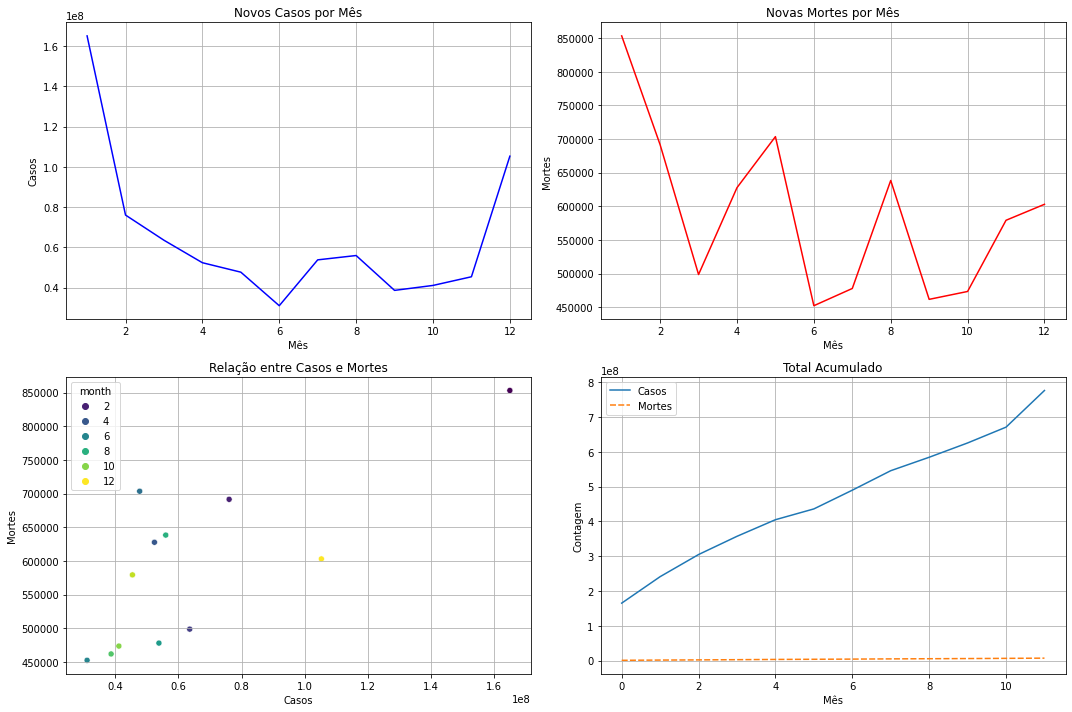

In [0]:
# Dashboard com filtros interativos
from pyspark.sql.functions import col
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
dashboard_df = spark.table("gold_fact_covid_cases") \
    .join(spark.table("gold_dim_country"), "country_code") \
    .join(spark.table("gold_dim_date"), "date") \
    .select("country_name", "continent", "date", "month", "year", 
            "total_cases", "new_cases", "total_deaths", "new_deaths")

# Obter listas de continentes e anos disponíveis
continents = [row.continent for row in dashboard_df.select("continent").distinct().collect()]
years = [row.year for row in dashboard_df.select("year").distinct().orderBy("year").collect()]

# Criar widgets com ipywidgets (funciona na Community Edition)
continent_dropdown = widgets.Dropdown(
    options=['Todos'] + continents,
    value='Todos',
    description='Continente:',
    disabled=False
)

year_dropdown = widgets.Dropdown(
    options=['Todos'] + years,
    value='Todos',
    description='Ano:',
    disabled=False
)

# Função para atualizar os gráficos
def update_plots(continent, year):
    # Aplicar filtros
    filtered_df = dashboard_df
    if continent != 'Todos':
        filtered_df = filtered_df.filter(col("continent") == continent)
    if year != 'Todos':
        filtered_df = filtered_df.filter(col("year") == year)
    
    # Converter para Pandas e agregar por mês
    pdf = filtered_df.groupBy("month").agg(
        {"new_cases": "sum", "new_deaths": "sum"}
    ).orderBy("month").toPandas()
    
    # Criar figura
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Novos casos por mês
    plt.subplot(2, 2, 1)
    sns.lineplot(x='month', y='sum(new_cases)', data=pdf, color='blue')
    plt.title('Novos Casos por Mês')
    plt.xlabel('Mês')
    plt.ylabel('Casos')
    plt.grid(True)
    
    # Gráfico 2: Novas mortes por mês
    plt.subplot(2, 2, 2)
    sns.lineplot(x='month', y='sum(new_deaths)', data=pdf, color='red')
    plt.title('Novas Mortes por Mês')
    plt.xlabel('Mês')
    plt.ylabel('Mortes')
    plt.grid(True)
    
    # Gráfico 3: Relação entre casos e mortes
    plt.subplot(2, 2, 3)
    sns.scatterplot(x='sum(new_cases)', y='sum(new_deaths)', data=pdf, hue='month', palette='viridis')
    plt.title('Relação entre Casos e Mortes')
    plt.xlabel('Casos')
    plt.ylabel('Mortes')
    plt.grid(True)
    
    # Gráfico 4: Total acumulado
    plt.subplot(2, 2, 4)
    pdf['cumulative_cases'] = pdf['sum(new_cases)'].cumsum()
    pdf['cumulative_deaths'] = pdf['sum(new_deaths)'].cumsum()
    sns.lineplot(data=pdf[['cumulative_cases', 'cumulative_deaths']])
    plt.title('Total Acumulado')
    plt.xlabel('Mês')
    plt.ylabel('Contagem')
    plt.legend(['Casos', 'Mortes'])
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Função para lidar com mudanças nos widgets
def on_change(change):
    update_plots(continent_dropdown.value, year_dropdown.value)

# Registrar callbacks
continent_dropdown.observe(on_change, names='value')
year_dropdown.observe(on_change, names='value')

# Exibir widgets e gráfico inicial
display(widgets.VBox([continent_dropdown, year_dropdown]))
update_plots(continent_dropdown.value, year_dropdown.value)

Quisemos demonstrar, portanto, é que há uma infinidade de opções disponíveis de grande utilidade para áreas de negócio, a fim de facilitar análises e incentivar melhorias no gerenciamento de processos.

## Catálogo de Dados

Um requisito importante em todo projeto é a presença do catálogo de dados. Nele, podemos observar as informações de metadados das tabelas, amostras destes dados e, também, as relações entre as camadas.
Logo abaixo, faremos esta representação para o nosso projeto.

**Metadados das Camadas**

Camada Bronze

In [0]:
# Célula 1: Metadados Bronze
bronze_meta = spark.sql("""
SELECT
  'bronze_covid_data' AS tabela,
  'dbfs:/mnt/covid_data/bronze/' AS localizacao,
  'Delta' AS formato,
  'Our World in Data' AS fonte,
  (SELECT COUNT(*) FROM (SELECT * FROM bronze_covid_data LIMIT 1)) AS qtd_colunas_estimada
""")
bronze_meta_df = bronze_meta.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
bronze_html = bronze_meta_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML (bronze_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
bronze_meta.show(truncate=False)

tabela,localizacao,formato,fonte,qtd_colunas_estimada
bronze_covid_data,dbfs:/mnt/covid_data/bronze/,Delta,Our World in Data,1


+-----------------+----------------------------+-------+-----------------+--------------------+
|tabela           |localizacao                 |formato|fonte            |qtd_colunas_estimada|
+-----------------+----------------------------+-------+-----------------+--------------------+
|bronze_covid_data|dbfs:/mnt/covid_data/bronze/|Delta  |Our World in Data|1                   |
+-----------------+----------------------------+-------+-----------------+--------------------+



In [0]:
# Célula 2: Visualização Bronze
bronze_sample = spark.sql("""
SELECT 
  iso_code AS codigo_pais, 
  location AS pais, 
  date AS data, 
  total_cases AS casos_totais
FROM 
  bronze_covid_data
WHERE 
  total_cases > 10000
ORDER BY 
  location 
LIMIT 5
""")
bronze_sample_df = bronze_sample.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
bronze_sample_html = bronze_sample_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML (bronze_sample_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
bronze_sample.show (truncate=False)

codigo_pais,pais,data,casos_totais
AFG,Afghanistan,2020-05-31,14443.0
AFG,Afghanistan,2020-06-03,14443.0
AFG,Afghanistan,2020-06-04,14443.0
AFG,Afghanistan,2020-06-01,14443.0
AFG,Afghanistan,2020-06-02,14443.0


+-----------+-----------+----------+------------+
|codigo_pais|pais       |data      |casos_totais|
+-----------+-----------+----------+------------+
|AFG        |Afghanistan|2020-05-31|14443.0     |
|AFG        |Afghanistan|2020-06-04|14443.0     |
|AFG        |Afghanistan|2020-06-01|14443.0     |
|AFG        |Afghanistan|2020-06-02|14443.0     |
|AFG        |Afghanistan|2020-06-03|14443.0     |
+-----------+-----------+----------+------------+



Camada Silver

In [0]:
# Célula 3: Dados Silver
silver_sample = spark.sql("""
SELECT 
  country_code AS codigo,
  country_name AS pais,
  date AS data,
  total_cases AS casos_totais,
  new_cases AS novos_casos
FROM 
  silver_covid_data
WHERE 
  continent = 'Europe' AND YEAR(date) = 2023
ORDER BY 
  date DESC
LIMIT 5
""")
silver_sample_df = silver_sample.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
silver_sample_html = silver_sample_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML (silver_sample_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
silver_sample.show(truncate=False)

codigo,pais,data,casos_totais,novos_casos
HRV,Croatia,2023-12-31,1309728.0,2800.0
CYP,Cyprus,2023-12-31,675109.0,3532.0
CZE,Czechia,2023-12-31,4746623.0,4359.0
DNK,Denmark,2023-12-31,3432346.0,1040.0
EST,Estonia,2023-12-31,608581.0,616.0


+--------+----------+----------+------------+-----------+
|codigo  |pais      |data      |casos_totais|novos_casos|
+--------+----------+----------+------------+-----------+
|POL     |Poland    |2023-12-31|6632065.0   |7419.0     |
|OWID_KOS|Kosovo    |2023-12-31|274279.0    |0.0        |
|MDA     |Moldova   |2023-12-31|631061.0    |838.0      |
|LUX     |Luxembourg|2023-12-31|390037.0    |346.0      |
|ESP     |Spain     |2023-12-31|1.398034E7  |null       |
+--------+----------+----------+------------+-----------+



Camada Gold

In [0]:
# Célula 4: Fato COVID
fact_sample = spark.sql("""
SELECT 
  f.country_code AS codigo_pais,
  c.country_name AS pais,
  f.date AS data,
  f.total_cases AS casos_totais,
  f.new_deaths AS novas_mortes
FROM 
  gold_fact_covid_cases f
JOIN 
  gold_dim_country c ON f.country_code = c.country_code
ORDER BY 
  f.new_deaths DESC
LIMIT 5
""")
fact_sample_df = fact_sample.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
fact_sample_html = fact_sample_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML (fact_sample_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
fact_sample.show(truncate=False)

codigo_pais,pais,data,casos_totais,novas_mortes
CHN,China,2023-02-05,98637553.0,47687.0
IND,India,2021-05-23,26530132.0,28982.0
IND,India,2021-05-16,24684077.0,27922.0
IND,India,2021-05-09,22296414.0,26820.0
IND,India,2021-05-30,27894800.0,26706.0


+-----------+-----+----------+------------+------------+
|codigo_pais|pais |data      |casos_totais|novas_mortes|
+-----------+-----+----------+------------+------------+
|CHN        |China|2023-02-05|9.8637553E7 |47687.0     |
|IND        |India|2021-05-23|2.6530132E7 |28982.0     |
|IND        |India|2021-05-16|2.4684077E7 |27922.0     |
|IND        |India|2021-05-09|2.2296414E7 |26820.0     |
|IND        |India|2021-05-30|2.78948E7   |26706.0     |
+-----------+-----+----------+------------+------------+



In [0]:
# Célula 5: Dimensão País
dim_country = spark.sql("""
SELECT 
  country_code AS codigo,
  country_name AS pais,
  continent AS continente,
  population AS populacao
FROM 
  gold_dim_country
WHERE 
  continent = 'South America'
LIMIT 5
""")
dim_country_df = dim_country.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
dim_country_html = dim_country_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML(dim_country_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
dim_country.show (truncate=False)


codigo,pais,continente,populacao
ARG,Argentina,South America,45510324
BOL,Bolivia,South America,12224114
BRA,Brazil,South America,215313504
CHL,Chile,South America,19603736
COL,Colombia,South America,51874028


+------+---------+-------------+---------+
|codigo|pais     |continente   |populacao|
+------+---------+-------------+---------+
|ARG   |Argentina|South America|45510324 |
|BOL   |Bolivia  |South America|12224114 |
|BRA   |Brazil   |South America|215313504|
|CHL   |Chile    |South America|19603736 |
|COL   |Colombia |South America|51874028 |
+------+---------+-------------+---------+



In [0]:
# Célula 6: Dimensão Data
dim_date = spark.sql("""
SELECT 
  date AS data_completa,
  year AS ano,
  month AS mes,
  day AS dia
FROM 
  gold_dim_date
WHERE 
  year = 2023
LIMIT 5
""")
dim_date_df = dim_date.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
dim_date_html = dim_date_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML(dim_date_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
dim_date.show (truncate=False)

data_completa,ano,mes,dia
2023-06-22,2023,6,22
2023-07-15,2023,7,15
2023-11-08,2023,11,8
2023-05-22,2023,5,22
2023-09-14,2023,9,14


+-------------+----+---+---+
|data_completa|ano |mes|dia|
+-------------+----+---+---+
|2023-06-22   |2023|6  |22 |
|2023-07-15   |2023|7  |15 |
|2023-11-08   |2023|11 |8  |
|2023-05-22   |2023|5  |22 |
|2023-09-14   |2023|9  |14 |
+-------------+----+---+---+



Relacionamentos

In [0]:
# Célula 7: Mapa de Relacionamentos
relationships = spark.sql("""
SELECT 
  'gold_fact_covid_cases' AS tabela_origem,
  'country_code' AS chave,
  'gold_dim_country' AS tabela_destino,
  'Muitos para Um' AS tipo_relacionamento
UNION ALL
SELECT 
  'gold_fact_covid_cases',
  'date',
  'gold_dim_date',
  'Muitos para Um'
""")
relationships_df = relationships.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
relationships_html = relationships_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML(relationships_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
relationships.show (truncate=False)

tabela_origem,chave,tabela_destino,tipo_relacionamento
gold_fact_covid_cases,country_code,gold_dim_country,Muitos para Um
gold_fact_covid_cases,date,gold_dim_date,Muitos para Um


+---------------------+------------+----------------+-------------------+
|tabela_origem        |chave       |tabela_destino  |tipo_relacionamento|
+---------------------+------------+----------------+-------------------+
|gold_fact_covid_cases|country_code|gold_dim_country|Muitos para Um     |
|gold_fact_covid_cases|date        |gold_dim_date   |Muitos para Um     |
+---------------------+------------+----------------+-------------------+



Verificações de qualidade

In [0]:
# Verificar chaves na tabela fato
spark.sql("""
SELECT 
  COUNT(DISTINCT country_code) AS dist_country_codes,
  COUNT(DISTINCT date) AS dist_dates
FROM 
  gold_fact_covid_cases
""").show()

+------------------+----------+
|dist_country_codes|dist_dates|
+------------------+----------+
|               243|      1688|
+------------------+----------+



In [0]:
# Célula 9: Verificação de Integridade
integrity_check = spark.sql("""
SELECT 
  'country_code' AS chave_verificada,
  (SELECT COUNT(DISTINCT country_code) FROM gold_fact_covid_cases) AS qtd_fato,
  (SELECT COUNT(DISTINCT country_code) FROM gold_dim_country) AS qtd_dimensao,
  CASE 
    WHEN (SELECT COUNT(*) FROM gold_fact_covid_cases f 
          LEFT JOIN gold_dim_country d ON f.country_code = d.country_code
          WHERE d.country_code IS NULL) = 0
    THEN 'OK' 
    ELSE 'INCONSISTENTE' 
  END AS status
""")
integrity_check_df = integrity_check.toPandas()
# Conversão Pandas para formato HTML, de melhor visualização
integrity_check_html = integrity_check_df.to_html(
  index=False,  # Remove a coluna de índice
  justify='center',  # Centraliza o texto
  classes='table table-striped table-bordered'  # Classes CSS para formatação
)
displayHTML(integrity_check_html)
# Mostra no formato tabular do Spark (caso haja algum problema na visualização interativa)
integrity_check.show(truncate=False)

chave_verificada,qtd_fato,qtd_dimensao,status
country_code,243,243,OK


+----------------+--------+------------+------+
|chave_verificada|qtd_fato|qtd_dimensao|status|
+----------------+--------+------------+------+
|country_code    |243     |243         |OK    |
+----------------+--------+------------+------+

